In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn


# Cloud type index = 37 
# clear = 0 
# stratus continental = 1 
# stratus maritime = 2 
# cumulus continental clean = 3 
# cumulus continental polluted = 4 
# cumulus maritime = 5 
# cirrus = 6 
# cirrus + water clouds (mixed) >= 7 

GIVE_ALL = False
DAY_TIME = False
USE_MIXED = False
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = False
LOW_VIS_FRAC = True
EVEN_CLOUDS = True
low_vis_frac = 0.45
low_vis_threshold = 1000 #50000 
cloud_types = [4] #0,1,2 ::: 0, 3, 4 
noise_level = 0.01 # fraction of max - min 
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
cloud_target_i = 37 # Cloud type index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate(([41], np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate(([41], np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

if GIVE_ALL:
   features_i = np.concatenate((np.arange(0, 30), (np.arange(31, 42))))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

data_ir_vis_str = data_ir_vis.copy()

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

index_col = np.arange(len(data_ir_vis)).reshape(-1, 1)  
data_ir_vis = np.hstack([data_ir_vis, index_col], dtype=np.float32)


# Some data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if DAY_TIME:
   #data_ir_vis = data_ir_vis[np.where(np.abs(data_ir_vis[:, 33] - 90) < 30)[0]]
   data_ir_vis = data_ir_vis[np.where(data_ir_vis[:, 32] < 30)[0]]



X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]
y_cloud = data_ir_vis[:, cloud_target_i].astype(int)


# Loop to clump together so that we have clear, stratus, cumulus and cirrus.
# for i in range(len(y_cloud)):
#     if y_cloud[i] == 2:
#         y_cloud[i] = 1
#     elif y_cloud[i] in [3, 4, 5]:
#         y_cloud[i] = 2
#     elif y_cloud[i] == 6:
#         y_cloud[i] = 3


ohe = OneHotEncoder()  
ohe.fit(y_cloud.reshape(-1, 1))
y_cloud_encoded = ohe.transform(y_cloud.reshape(-1, 1))
Y = y_cloud_encoded.toarray()


noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, Y, test_size=(1/20))
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=(1/19))

X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)


2024-04-10 09:17:34.619132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 09:17:34.652801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 09:17:34.652824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 09:17:34.653650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 09:17:34.659128: I tensorflow/core/platform/cpu_feature_guar

In [32]:
unique, counts = np.unique(y_cloud, return_counts=True)

print(unique)
print(counts)

[0 1 2 3]
[150000  59971  90029 149970]


In [37]:
import xgboost as xgb

Y_train_class = np.argmax(Y_train, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

#neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=Y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=Y_test_class)

params = {
    'objective': 'multi:softmax',  # Use multiclass objective
    'max_depth': 20,
    'learning_rate': 0.05,
    'num_class': 7  # Specify the number of classes (0 to 6)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
Y_pred_class = model.predict(dtest)
#Y_pred_class = np.argmax(Y_pred, axis=1)  # Get class with the highest probability 



print(classification_report(Y_test_class, Y_pred_class))
# cm = confusion_matrix(y_test_class, y_pred_class)
# plt.figure(figsize=(8,6))
# sn.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Scatter Plot
# plt.figure(figsize=(6, 4))
# plt.scatter(y_test_class[:100], y_pred[:100], s=1)
# plt.axhline(y=0.5, color='r', linestyle='-') 
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7558
           1       0.27      0.32      0.29      1471
           2       0.30      0.27      0.29      1489
           3       0.31      0.24      0.27      1522
           4       0.53      0.51      0.52      1468
           5       0.36      0.43      0.39      1480
           6       0.99      0.99      0.99      7511

    accuracy                           0.78     22499
   macro avg       0.54      0.54      0.54     22499
weighted avg       0.78      0.78      0.78     22499



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7558
           1       0.27      0.32      0.29      1471
           2       0.30      0.27      0.29      1489
           3       0.31      0.24      0.27      1522
           4       0.53      0.51      0.52      1468
           5       0.36      0.43      0.39      1480
           6       0.99      0.99      0.99      7511

    accuracy                           0.78     22499
   macro avg       0.54      0.54      0.54     22499
weighted avg       0.78      0.78      0.78     22499



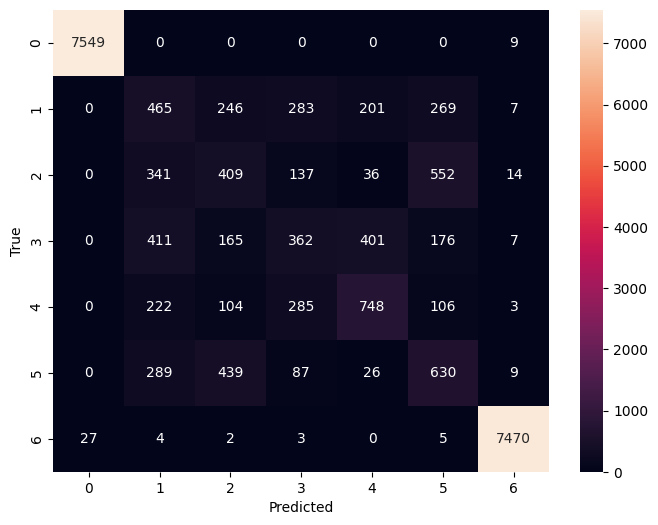

In [38]:
# All cloud types

print(classification_report(Y_test_class, Y_pred_class))
cm = confusion_matrix(Y_test_class, Y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7479
           1       0.49      0.30      0.37      3001
           2       0.63      0.79      0.70      4524
           3       0.99      0.99      0.99      7495

    accuracy                           0.86     22499
   macro avg       0.78      0.77      0.77     22499
weighted avg       0.85      0.86      0.85     22499



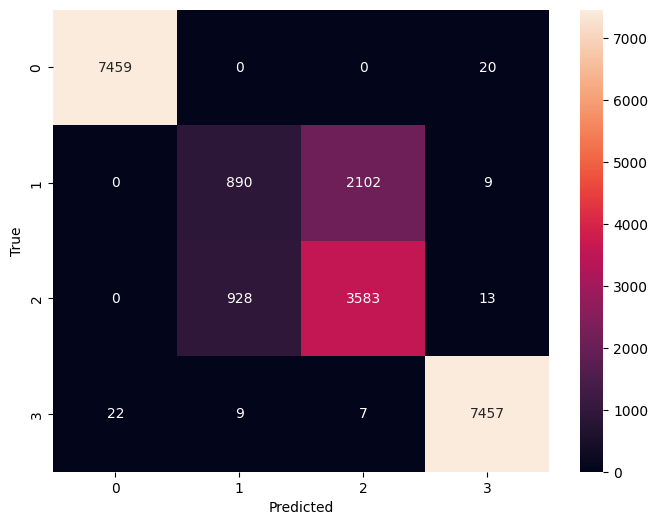

In [35]:
# Clear, stratus, cumulus and cirrus.

print(classification_report(Y_test_class, Y_pred_class))
cm = confusion_matrix(Y_test_class, Y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [29]:
#Classification all clouds, no changes in data

print(classification_report(Y_test_class, Y_pred_class))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7491
           1       0.27      0.32      0.29      1474
           2       0.30      0.29      0.29      1491
           3       0.28      0.22      0.25      1487
           4       0.53      0.49      0.51      1555
           5       0.37      0.42      0.39      1479
           6       0.99      0.99      0.99      7522

    accuracy                           0.78     22499
   macro avg       0.53      0.53      0.53     22499
weighted avg       0.78      0.78      0.78     22499



Old code for fog/nofog

In [ ]:
# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test_reg = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]

    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
       

    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
    y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])


# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train_reg, y_val_reg = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_class = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold, 1, 0)
y_val_class = np.where(target_scaler.inverse_transform(y_val_reg) < low_vis_threshold, 1, 0)
y_test_class = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_reg)).batch(batch_size=dnn_batch_size)
training_data_class = tf.data.Dataset.from_tensor_slices((X_train, y_train_class)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_class = training_data_class.map(noise_map)

In [20]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder()  

# Fit the encoder to your data (learn the categories)
ohe.fit(y_cloud.reshape(-1, 1))  # Reshape to 2D for fitting

# Transform your target labels into a one-hot encoded matrix
target_encoded = ohe.transform(y_cloud.reshape(-1, 1))



print(target_encoded.toarray()[0])


[1. 0. 0. 0. 0. 0. 0.]


[6. 6. 6. ... 4. 1. 1.]
cloud: 0
0.0
150000
cloud: 1
0.15648588434808633
30073
cloud: 2
0.14121345909425378
29898
cloud: 3
0.16515487468924275
29766
cloud: 4
0.17395639457591067
30088
cloud: 5
0.13295774647887323
30175
cloud: 6
0.12266453290658132
149970


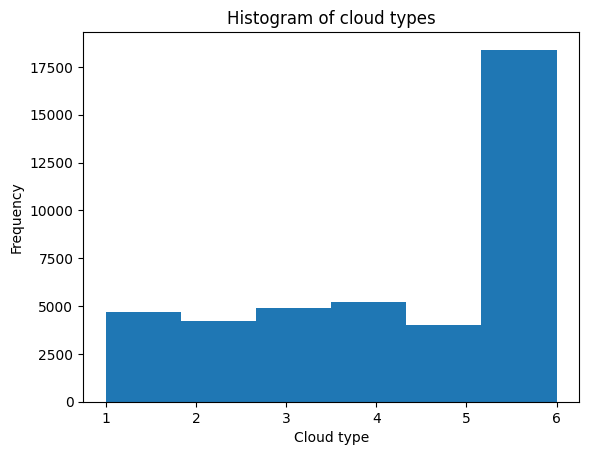

In [6]:
low_vis_data_i = np.where(data_ir_vis[:,30] < low_vis_threshold)[0]
print(data_ir_vis[low_vis_data_i, 37])

for cloud in range(7):
    print(f'cloud: {cloud}')
    print(len(np.where(data_ir_vis[low_vis_data_i, 37] == cloud)[0]) / len(np.where(data_ir_vis[:, 37] == cloud)[0]))
    print(len(np.where(data_ir_vis[:, 37] == cloud)[0]))




plt.hist(data_ir_vis[low_vis_data_i, 37] , bins=6)
plt.xlabel("Cloud type")
plt.ylabel("Frequency")
plt.title("Histogram of cloud types")
plt.show()